# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization, 
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided, 
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

In [13]:
from tslearn.datasets import UCR_UEA_datasets
from keras.utils import to_categorical

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
print(X_train.shape)


y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)
print(X_train.shape, y_train.shape, y_train_cat.shape, y_test_cat.shape)

num_categories = y_train_cat.shape[-1]

(1000, 128, 1)
(1000, 128, 1) (1000,) (1000, 4) (4000, 4)


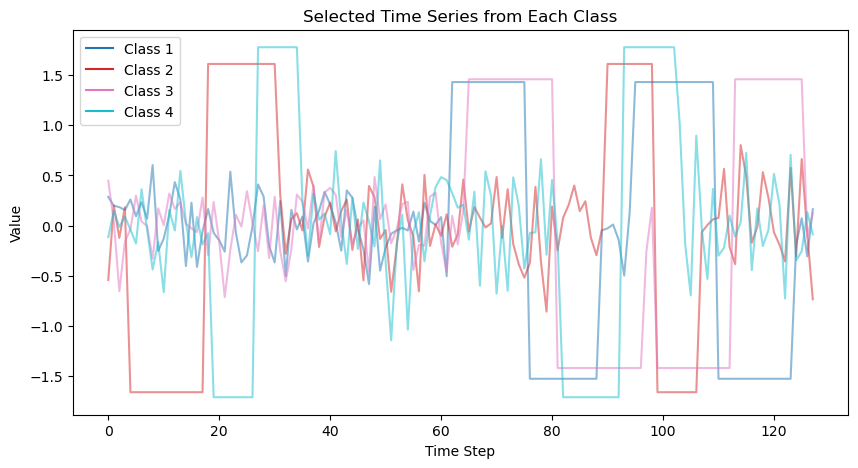

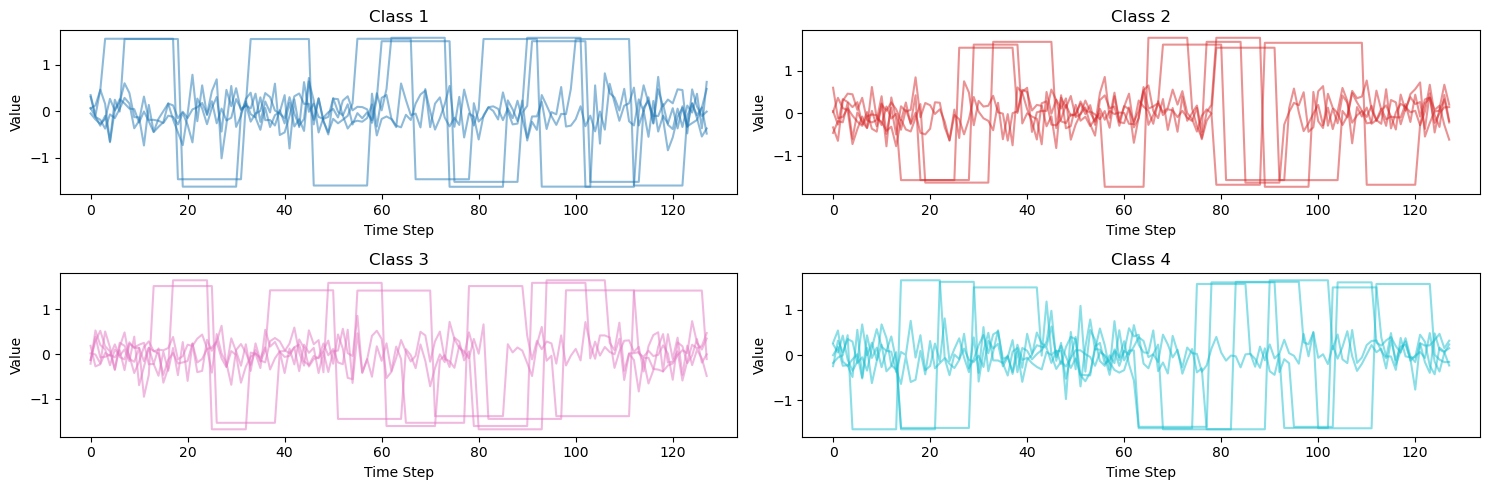

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_classes(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Plot all selected samples for this class at once
        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        # Add a legend entry for this class
        ax.plot([], [], color=colors[idx], label=f'Class {cls}')

    ax.legend()
    plt.title('Selected Time Series from Each Class')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()


def plot_selected_classes_subplots(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Calculate the number of rows needed for subplots based on the number of classes
    num_rows = int(np.ceil(num_classes / 2))  # Adjust the denominator to control how many columns you want
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2.5), squeeze=False)

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Determine which subplot to use
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        ax.set_title(f'Class {cls}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_selected_classes(X_train, y_train, 1)
plot_selected_classes_subplots(X_train, y_train, 5)

In [15]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm.notebook import tqdm
import multiprocessing

# Function to evaluate clustering quality
def evaluate_clustering(X_train_scaled, params):
    n_clusters = params['n_clusters']
    gamma = params['gamma']
    
    # Fit the model and predict clusters in one step
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma": gamma}, n_jobs=multiprocessing.cpu_count() * 2 // 3, random_state=0)
    y_pred = km.fit_predict(X_train_scaled)

    # Compute the silhouette score
    score = silhouette_score(X_train_scaled, y_pred, metric="softdtw", metric_params={"gamma": gamma})
    
    return {'n_clusters': n_clusters, 'gamma': gamma, 'score': score}


In [16]:
# Preprocess the time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

sample_size = 50  # Adjust this value to your desired sample size
random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]

# Define parameter grid for grid search
param_grid = [{'n_clusters': n_clusters, 'gamma': gamma} for n_clusters in range(2, 5) for gamma in [0.01, 0.1, 1, 10]]

# Perform grid search with tqdm progress bar using list comprehension
results = [evaluate_clustering(X_train_sample, params) for params in tqdm(param_grid, desc="Grid search progress")]


# Find the best parameters
best_params = max(results, key=lambda x: x['score'])
best_n_clusters = best_params['n_clusters']
best_gamma = best_params['gamma']
best_score = best_params['score']

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best gamma for soft-DTW: {best_gamma}")
print(f"Best silhouette score: {best_score}")

Grid search progress:   0%|          | 0/12 [00:00<?, ?it/s]

Best number of clusters: 4
Best gamma for soft-DTW: 0.01
Best silhouette score: 0.7265988637056404


In [17]:
# Fit the final model with the best parameters
final_km = TimeSeriesKMeans(n_clusters=best_n_clusters, 
                            metric="softdtw", 
                            metric_params={"gamma": best_gamma},
                            verbose=1, 
                            random_state=0)
final_km.fit(X_train_sample)

# Plot the barycenters
# plt.figure(figsize=(10, 5))
# for i in range(best_n_clusters):
#     plt.plot(final_km.cluster_centers_[i], label=f'Barycenter {i+1}')
# plt.legend()
# plt.title('Barycenters of the clusters')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.show()

77.494 --> 30.629 --> 30.655 --> 30.625 --> 30.624 --> 30.622 --> 30.602 --> 30.593 --> 30.556 --> 30.527 --> 30.533 --> 30.518 --> 30.521 --> 30.515 --> 30.522 --> 30.501 --> 30.507 --> 30.496 --> 30.502 --> 30.493 --> 30.502 --> 30.488 --> 30.492 --> 30.472 --> 30.471 --> 30.465 --> 30.466 --> 30.461 --> 30.461 --> 30.459 --> 30.459 --> 30.458 --> 30.458 --> 30.457 --> 30.458 --> 30.457 --> 30.458 --> 30.457 --> 30.457 --> 30.457 --> 30.457 --> 30.456 --> 30.456 --> 30.456 --> 30.456 --> 30.455 --> 30.456 --> 30.455 --> 30.455 --> 30.455 --> 


TimeSeriesKMeans(metric='softdtw', metric_params={'gamma': 0.01}, n_clusters=4,
                 random_state=0, verbose=1)

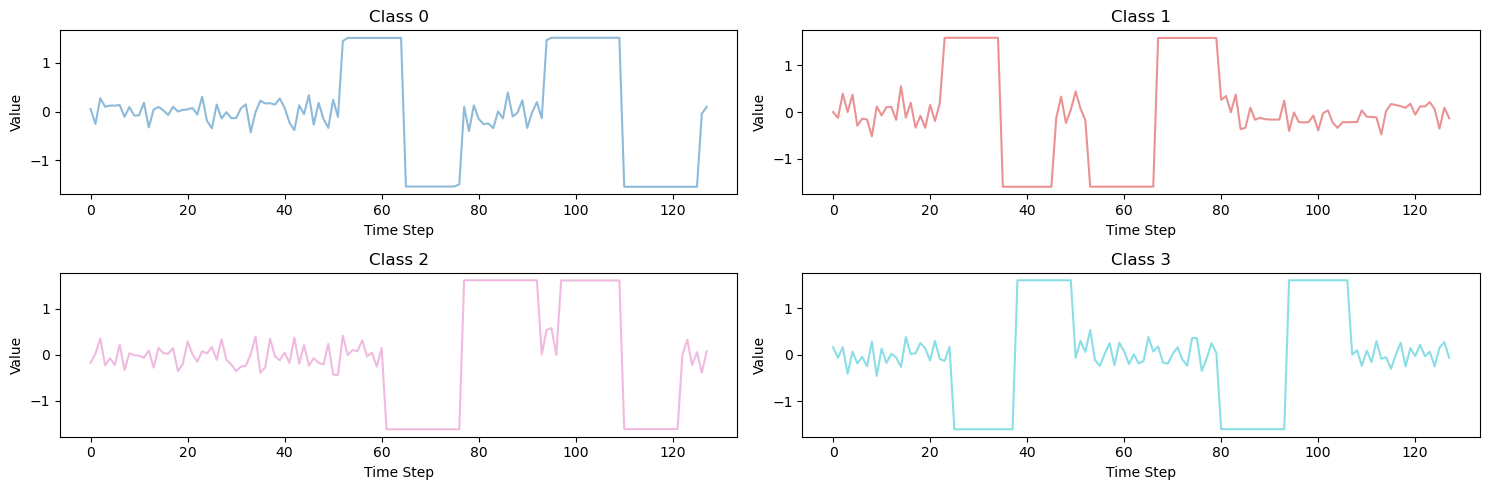

In [18]:
plot_selected_classes_subplots(final_km.cluster_centers_, list(range(final_km.n_clusters)), 1)

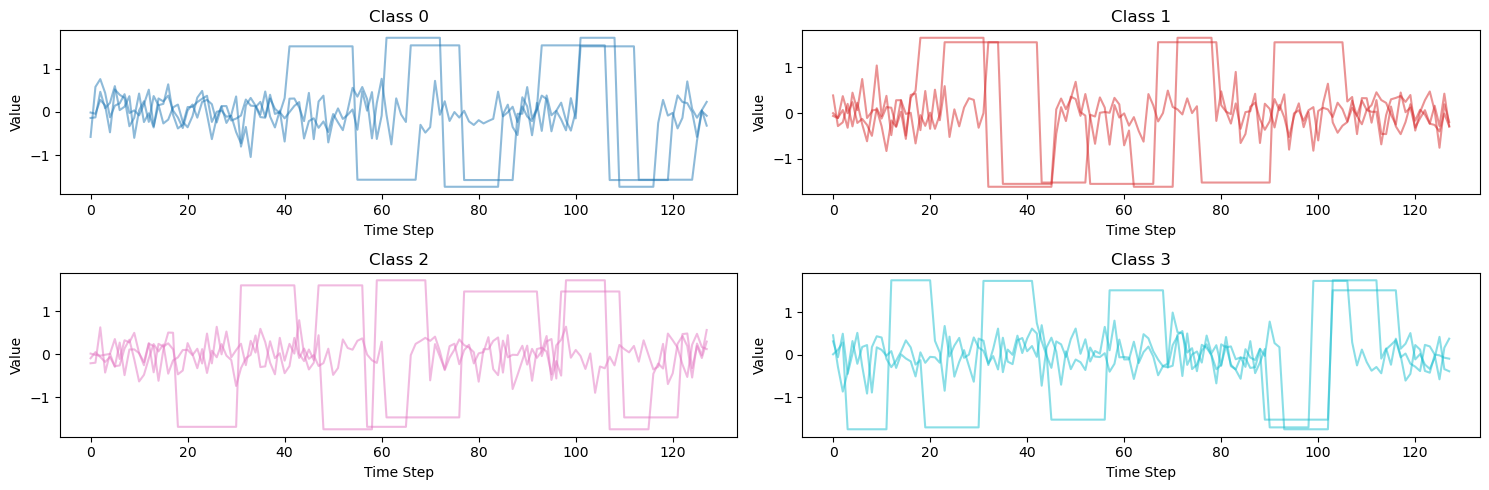

In [19]:
plot_selected_classes_subplots(X_train_sample, final_km.labels_, 3)

In [20]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_cnn_attention_model(input_shape, num_categories, conv_configs, dense_units=50, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for config in conv_configs:
        filters = config['filters']
        kernel_size = config['kernel_size']
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        
        if config.get('attention'):
            # Reshape for attention if necessary. Attention requires the input shape as (batch_size, sequence, features).
            # After Conv1D and Pooling layers, the shape should already be compatible.
            query = value = x
            attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                            key_dim=config['attention']['key_dim'],
                                            dropout=dropout_rate)(query, value, value)
            x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
            x = Dropout(dropout_rate)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
conv_configs = [
    {'filters': 64, 'kernel_size': 3, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 3},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 3, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]

cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs)

cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
cnn_attention_model.summary()

Epoch 1/100
32/32 [==============================] - 3s 19ms/step - loss: 1.3275 - accuracy: 0.4030 - val_loss: 0.8899 - val_accuracy: 0.6455
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.5354 - accuracy: 0.7990 - val_loss: 0.2077 - val_accuracy: 0.9415
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.1047 - accuracy: 0.9770 - val_loss: 0.0559 - val_accuracy: 0.9865
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0302 - accuracy: 0.9950 - val_loss: 0.0362 - val_accuracy: 0.9908
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0352 - accuracy: 0.9920 - val_loss: 0.0193 - val_accuracy: 0.9935
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0106 - accuracy: 0.9980 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9975
Epoch 

In [22]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_lstm_attention_model(input_shape, num_categories, lstm_configs, dense_units=50, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i, config in enumerate(lstm_configs):
        lstm_units = config['units']
        return_sequences = True if i < len(lstm_configs) - 1 else False
        x = LSTM(lstm_units, return_sequences=return_sequences)(x)
        
        if config.get('attention'):
            # Assuming the attention layer is applied after the LSTM layer
            if return_sequences:
                # MultiHeadAttention expects inputs as (batch_size, sequence_length, features),
                # which matches the output shape of LSTM with return_sequences=True
                query = value = x
                attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                                key_dim=config['attention']['key_dim'],
                                                dropout=dropout_rate)(query, value, value)
                x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
                x = Dropout(dropout_rate)(x)
    
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_configs = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  # LSTM layer followed by attention
]

lstm_attention_model = create_lstm_attention_model(X_train[0].shape, num_categories, lstm_configs)
lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
lstm_attention_model.summary()

Epoch 1/100
32/32 [==============================] - 6s 59ms/step - loss: 1.0361 - accuracy: 0.4870 - val_loss: 0.7735 - val_accuracy: 0.5935
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6745 - accuracy: 0.6580 - val_loss: 0.5122 - val_accuracy: 0.7825
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.4061 - accuracy: 0.8460 - val_loss: 0.2521 - val_accuracy: 0.9298
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.1189 - accuracy: 0.9760 - val_loss: 0.3039 - val_accuracy: 0.9202
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.2146 - accuracy: 0.9330 - val_loss: 0.1694 - val_accuracy: 0.9442
Epoch 6/100
32/32 [==============================] - 1s 32ms/step - loss: 0.1438 - accuracy: 0.9500 - val_loss: 0.0462 - val_accuracy: 0.9925
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0481 - accuracy: 0.9880 - val_loss: 0.0383 - val_accuracy: 0.9895
Epoch 

In [23]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras

def create_transformer_model(input_shape, num_categories, num_layers=3, d_model=64, num_heads=4, dff=256, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Initial projection of input to the desired dimension (d_model)
    x = Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
        
    # Pooling layer to reduce the sequence dimension
    pooled_output = GlobalAveragePooling1D()(x)
    
    # Output layer for classification
    outputs = Dense(num_categories, activation='softmax')(pooled_output)
    
    model = Model(inputs, outputs)
    return model

transformer_model = create_transformer_model(X_train[0].shape, num_categories, num_layers=1)
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
transformer_model.summary()

Epoch 1/100
32/32 [==============================] - 3s 21ms/step - loss: 1.4472 - accuracy: 0.2450 - val_loss: 1.4182 - val_accuracy: 0.2573
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 1.4023 - accuracy: 0.2620 - val_loss: 1.3846 - val_accuracy: 0.2677
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 1.3997 - accuracy: 0.2540 - val_loss: 1.3783 - val_accuracy: 0.2632
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 1.4068 - accuracy: 0.2500 - val_loss: 1.3866 - val_accuracy: 0.2610
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 1.3955 - accuracy: 0.2920 - val_loss: 1.4053 - val_accuracy: 0.2685
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 1.3841 - accuracy: 0.2770 - val_loss: 1.3786 - val_accuracy: 0.2803
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 1.3779 - accuracy: 0.2920 - val_loss: 1.3777 - val_accuracy: 0.3022
Epoch 

In [24]:
import numpy as np

def prepare_forecasting_data(X, t):
    """
    Prepares training data for forecasting the next T-t timesteps from the first t timesteps.
    
    Parameters:
    - X: numpy array of shape (n_series, T, n_features), original dataset.
    - t: int, number of timesteps to use as input.
    
    Returns:
    - X_input: Input data consisting of the first t timesteps from each series.
    - X_target: Target data consisting of the next T-t timesteps from each series.
    """
    X_input = X[:, :t, :]
    X_target = X[:, t:, :]
    
    return X_input, X_target

# Example usage
t = 64  # Number of timesteps given as input
X_train_input, X_train_target = prepare_forecasting_data(X_train, t)
X_test_input, X_test_target = prepare_forecasting_data(X_test, t)

print("Training input shape:", X_train_input.shape)
print("Training target shape:", X_train_target.shape)
print("Testing input shape:", X_test_input.shape)
print("Testing target shape:", X_test_target.shape)


Training input shape: (1000, 64, 1)
Training target shape: (1000, 64, 1)
Testing input shape: (4000, 64, 1)
Testing target shape: (4000, 64, 1)


In [31]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def create_forecasting_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(128, return_sequences=False)(inputs)
    # Repeat the encoding for each time step
    repeated_encoding = RepeatVector(output_shape[0])(encoded)
    # Decoder
    decoded = LSTM(128, return_sequences=True)(repeated_encoding)
    # TimeDistributed layer for output
    outputs = TimeDistributed(Dense(output_shape[1]))(decoded)
    
    model = Model(inputs, outputs)
    return model

# Example usage
t = 64  # Let's say we're given the first 64 steps and need to predict the next 64
forecasting_lstm_model = create_forecasting_lstm_model(X_train_input.shape[1:], X_train_target.shape[1:])
forecasting_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_lstm_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)
forecasting_lstm_model.summary()

Epoch 1/10
32/32 [==============================] - 3s 26ms/step - loss: 1.2028 - mae: 0.8710 - val_loss: 0.7764 - val_mae: 0.6377
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1638 - mae: 0.8579 - val_loss: 0.7617 - val_mae: 0.6262
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 1.1469 - mae: 0.8494 - val_loss: 0.7664 - val_mae: 0.6290
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 1.1333 - mae: 0.8415 - val_loss: 0.8092 - val_mae: 0.6605
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 1.1261 - mae: 0.8361 - val_loss: 0.7861 - val_mae: 0.6407
Epoch 6/10
32/32 [==============================] - 0s 11ms/step - loss: 1.1173 - mae: 0.8294 - val_loss: 0.7641 - val_mae: 0.6264
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 1.1139 - mae: 0.8272 - val_loss: 0.7681 - val_mae: 0.6284
Epoch 8/10
32/32 [==============================] - 0s 11ms/step - loss: 1.1077 - m

In [34]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

def create_forecasting_transformer_model(input_shape, num_layers, d_model, num_heads, dff, output_shape, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    # Adapt the Transformer to output a sequence of the desired length
    x = Dense(output_shape[0])(x)
    outputs = Dense(output_shape[1])(x)  # Assuming a single feature per timestep in the output
    
    model = Model(inputs, outputs)
    return model

# Example usage for the Transformer model
forecasting_transformer_model = create_forecasting_transformer_model(
    input_shape=X_train_input.shape[1:],
    num_layers=3,
    d_model=64,
    num_heads=4,
    dff=256,
    output_shape=X_train_target.shape[1:],
    dropout_rate=0.1
)
forecasting_transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_transformer_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)
forecasting_transformer_model.summary()

Epoch 1/10
32/32 [==============================] - 6s 29ms/step - loss: 2.1564 - mae: 1.1369 - val_loss: 0.8001 - val_mae: 0.6630
Epoch 2/10
32/32 [==============================] - 1s 18ms/step - loss: 1.2518 - mae: 0.8946 - val_loss: 0.7421 - val_mae: 0.6144
Epoch 3/10
32/32 [==============================] - 1s 19ms/step - loss: 1.2304 - mae: 0.8832 - val_loss: 0.7431 - val_mae: 0.6146
Epoch 4/10
32/32 [==============================] - 1s 21ms/step - loss: 1.2260 - mae: 0.8817 - val_loss: 0.7432 - val_mae: 0.6163
Epoch 5/10
32/32 [==============================] - 1s 19ms/step - loss: 1.2246 - mae: 0.8806 - val_loss: 0.7445 - val_mae: 0.6172
Epoch 6/10
32/32 [==============================] - 1s 20ms/step - loss: 1.2243 - mae: 0.8802 - val_loss: 0.7419 - val_mae: 0.6148
Epoch 7/10
32/32 [==============================] - 1s 19ms/step - loss: 1.2216 - mae: 0.8787 - val_loss: 0.7412 - val_mae: 0.6141
Epoch 8/10
32/32 [==============================] - 1s 18ms/step - loss: 1.2206 - m